Import Libraries

In [1]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt
import pywt
from math import ceil
from ecgdetectors import Detectors

Define path

In [2]:
dataset_path = '/home/ravisane/Downloads/MTP/ptbdb/'
data = open('/home/ravisane/Downloads/MTP/ptbdb/RECORDS.txt', 'r')

Define init values

In [3]:
num_samples = 9000     # no of samples to read from each  record
records = 549          # total records
num_leads = 12         # 12 leads out of given 15 to be choosen
fields = []
signals = []
wave = 'db9'           # db9 wavelet used
dec_levels = 6         # 6 level decomposition used
max_eig_values = 6     # top 6 eigen values to be taken of cov matrix of 4 subbands coeff
max_dec_levels = 4     # 4 subbands choosen cA6 cD6 cD5 cD4
M = 25                 # mov avg filter

Filtering using M point MA Filter and storing the resultant into signals and fields.

In [4]:
# input the data from the ptb dataset
for i in data:
    sig, f = wfdb.rdsamp(dataset_path + i[:-1], channels=[x for x in range(num_leads)], sampfrom=0, sampto=num_samples)
    
    s = np.zeros((num_samples-M+1, num_leads))
    for leads in range(num_leads):
        s[:,leads] = np.convolve(sig[:,leads], np.ones((M,))/M, mode='valid')
    
    if(f['comments'][4] == 'Reason for admission: Myocardial infarction'):        
        sampling_freq = f['fs']
        detectors = Detectors(sampling_freq)
        
        r_peaks = detectors.pan_tompkins_detector(s[:,0]) # apply tompkins algo to get r peaks
        
        signals += [s[r_peaks[0]:r_peaks[1]]]             # select 1 heartbeat
        fields += [f]
        
        signals += [s[r_peaks[1]:r_peaks[2]]]             # select 1 heartbeat
        fields += [f]
        
        signals += [s[r_peaks[2]:r_peaks[3]]]             # select 1 heartbeat
        fields += [f]
        
        signals += [s[r_peaks[3]:r_peaks[4]]]             # select 1 heartbeat
        fields += [f]
records *= 4        

Show plot of one record, not an important step

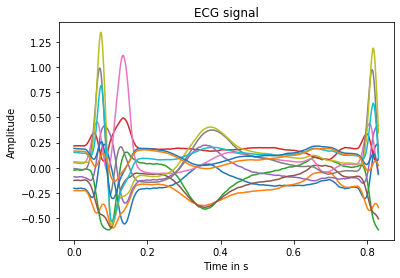

In [5]:
#%% Plot the graph of all 12 ECG signals of patient record number 0 ----NOT IMPORTANT STEP
t = np.arange(0, (len(signals[0])/sampling_freq), (1/ sampling_freq))
plt.plot(t, signals[0])
plt.title("ECG signal")
plt.xlabel("Time in s")
plt.ylabel("Amplitude")
plt.show()  

Performing 6 level wavelet decomposition using db9 wavelet

In [6]:
records = len(signals)
coeff = []
for patient in range(records):
    coeff += [pywt.wavedec(signals[patient], wavelet = wave, mode = 'zero', level = dec_levels, axis = 0)]


/home/ravisane/anaconda3/lib/python3.7/site-packages/pywt/_multilevel.py:45: UserWarning: Level value of 6 is too high: all coefficients will experience boundary effects.
  "boundary effects.").format(level))


Plotting the subband coeff for one record

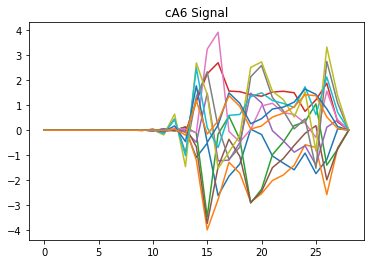

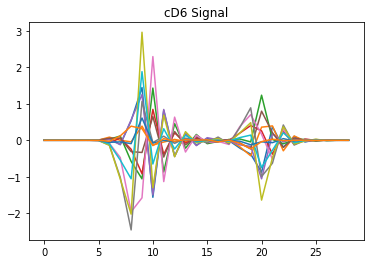

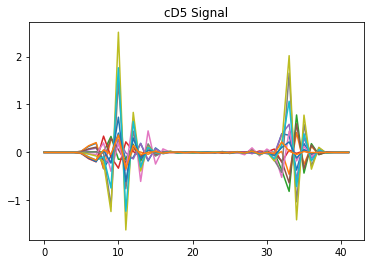

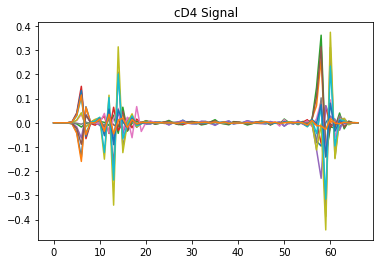

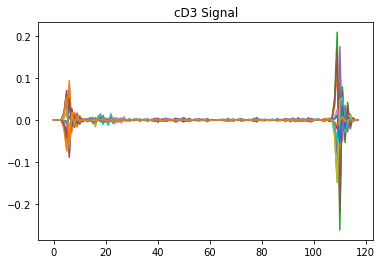

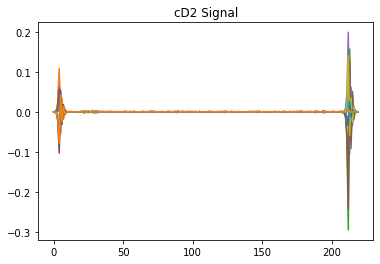

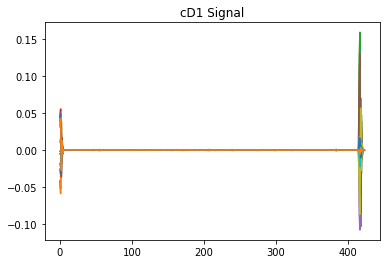

In [7]:
c = coeff
#plt.figure(1)
#plt.subplot(4,2,1)
t = np.arange(0, len(c[0][0]), 1)
plt.plot(t, c[0][0])
plt.title("cA6 Signal")
plt.show()

#plt.subplot(4,2,2)
t = np.arange(0, len(c[0][1]), 1)
plt.plot(t, c[0][1])
plt.title("cD6 Signal")
plt.show()

#plt.subplot(4,2,3)
t = np.arange(0, len(c[0][2]), 1)
plt.plot(t, c[0][2])
plt.title("cD5 Signal")
plt.show()

#plt.subplot(4,2,4)
t = np.arange(0, len(c[0][3]), 1)
plt.plot(t, c[0][3])
plt.title("cD4 Signal")
plt.show()

#plt.subplot(4,2,5)
t = np.arange(0, len(c[0][4]), 1)
plt.plot(t, c[0][4])
plt.title("cD3 Signal")
plt.show()

#plt.subplot(4,2,6)
t = np.arange(0, len(c[0][5]), 1)
plt.plot(t, c[0][5])
plt.title("cD2 Signal")
plt.show()

#plt.subplot(4,2,7)
t = np.arange(0, len(c[0][6]), 1)
plt.plot(t, c[0][6])
plt.title("cD1 Signal")
plt.show()

Calculate energy vectors for each record, we choose 4 subbands * 12 ecg leads => 48 long vector
Normalize this energy vector

In [8]:
#%% Get normalized energy from the coefficient matrix
energy = np.zeros((records, max_dec_levels, num_leads))
energy_vector = np.zeros((records, max_dec_levels*num_leads))
normalized_energy_vector = np.zeros((records, max_dec_levels*num_leads))

for patient in range(records):
    for levels in range(max_dec_levels):               # 4 levels to keep that is cA6 cD6 cD5 cD4
        for leads in range(num_leads):
            temp_sum = 0
            for xx in coeff[patient][levels][:][leads]:
                temp_sum += xx
            energy[patient,levels,leads] = temp_sum/len(coeff[patient][levels][:][leads])
    
    energy_vector[patient,:] = np.reshape(energy[patient,:,:], (4*num_leads)) # 48 long vector
    normalized_energy_vector[patient] = energy_vector[patient]/max(energy_vector[patient])


Get eigen values of covariance matrix of 4 subband coefficient and find principal eigen values (we choose 6 values) => 24 long eigen vector

In [9]:
eig_value_vector = np.zeros((records, max_dec_levels*max_eig_values))
# normalized_eig_value_vector = np.zeros((records, max_dec_levels*max_eig_values))

for patient in range(records):
    princ_eig_value = []
    for levels in range(max_dec_levels):
        eig_value, eig_vector = np.linalg.eig(np.cov(np.array(coeff[patient][levels])))
        princ_eig_value = princ_eig_value + [np.sort(np.real(eig_value))[-max_eig_values:]]                  
    eig_value_vector[patient] = np.reshape(np.array(princ_eig_value),(4*max_eig_values))
    # normalized_eig_value_vector[patient] = eig_value_vector[patient]#/max(eig_value_vector[patient])

Concatenate the two vectors to get 72 length vector

In [10]:
# Get feature matrix by 48 energy values and 24 eigen values
Z = np.concatenate((normalized_energy_vector, eig_value_vector), axis = 1)

Create Labels for training purpose

In [21]:
#%% To find labels for classification training of classifiers
Z_AMI = []
Z_IMI = []
Z_ALMI = []
Z_ASMI = []
Z_ILMI = []
Z_IPLMI = []

y_AMI = []
y_IMI = []
y_ALMI = []
y_ASMI = []
y_ILMI = []
y_IPLMI = []

for patient in range(records):
    if(fields[patient]['comments'][5] == 'Acute infarction (localization): infero-latera' or fields[patient]['comments'][5] == 'Acute infarction (localization): infero-lateral'):        
        Z_ILMI.append(Z[patient])
        y_ILMI.append(0)
    elif(fields[patient]['comments'][5] == 'Acute infarction (localization): anterior'):
        Z_AMI.append(Z[patient])
        y_AMI.append(1)
    elif(fields[patient]['comments'][5] == 'Acute infarction (localization): infero-postero-lateral' or fields[patient]['comments'][5] == 'Acute infarction (localization): infero-poster-lateral'):
        Z_IPLMI.append(Z[patient])
        y_IPLMI.append(2)
    elif(fields[patient]['comments'][5] == 'Acute infarction (localization): antero-septal'):
        Z_ASMI.append(Z[patient])
        y_ASMI.append(3)
    elif(fields[patient]['comments'][5] == 'Acute infarction (localization): inferior'):
        Z_IMI.append(Z[patient])
        y_IMI.append(4)
    elif(fields[patient]['comments'][5] == 'Acute infarction (localization): antero-lateral'):
        Z_ALMI.append(Z[patient])
        y_ALMI.append(5)

Z_AMI = np.array(Z_AMI)
Z_IMI = np.array(Z_IMI)
Z_ALMI = np.array(Z_ALMI)
Z_ASMI = np.array(Z_ASMI)
Z_ILMI = np.array(Z_ILMI)
Z_IPLMI = np.array(Z_IPLMI)

y_AMI = np.array(y_AMI)
y_IMI = np.array(y_IMI)
y_ALMI = np.array(y_ALMI)
y_ASMI = np.array(y_ASMI)
y_ILMI = np.array(y_ILMI)
y_IPLMI = np.array(y_IPLMI)

Apply 5 fold CV and clasifiers KNN, linear SVM, rbf SVM

In [22]:
#%% Apply 5 fold CV and clasifiers KNN, linear SVM, rbf SVM
from sklearn.model_selection import KFold
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

scores_knn = []
scores_linear = []
scores_rbf = []

neigh = KNeighborsClassifier(n_neighbors = 5)
# svc_linear = SVC(kernel = 'linear')
# svc_rbf = SVC(kernel = 'rbf')

svc_linear = make_pipeline(StandardScaler(), SVC(kernel = 'linear'))
svc_rbf = make_pipeline(StandardScaler(), SVC(kernel = 'rbf'))

cv = KFold(n_splits = 5, shuffle = True)

for train_index, test_index in cv.split(Z_IPLMI):
    X_train, X_test, y_train, y_test = Z_IPLMI[train_index], Z_IPLMI[test_index], y_IPLMI[train_index], y_IPLMI[test_index]
    X_train = np.append(X_train, Z_ILMI[train_index], axis = 0)
    X_test = np.append(X_test, Z_ILMI[test_index], axis = 0)
    y_train = np.append(y_train, y_ILMI[train_index], axis = 0)
    y_test = np.append(y_test, y_ILMI[test_index], axis = 0)
    
    X_train = np.append(X_train, Z_ASMI[train_index], axis = 0)
    X_test = np.append(X_test, Z_ASMI[test_index], axis = 0)
    y_train = np.append(y_train, y_ASMI[train_index], axis = 0)
    y_test = np.append(y_test, y_ASMI[test_index], axis = 0)
    
    X_train = np.append(X_train, Z_ALMI[train_index], axis = 0)
    X_test = np.append(X_test, Z_ALMI[test_index], axis = 0)
    y_train = np.append(y_train, y_ALMI[train_index], axis = 0)
    y_test = np.append(y_test, y_ALMI[test_index], axis = 0)
    
    X_train = np.append(X_train, Z_AMI[train_index], axis = 0)
    X_test = np.append(X_test, Z_AMI[test_index], axis = 0)
    y_train = np.append(y_train, y_AMI[train_index], axis = 0)
    y_test = np.append(y_test, y_AMI[test_index], axis = 0)
    
    X_train = np.append(X_train, Z_IMI[train_index], axis = 0)
    X_test = np.append(X_test, Z_IMI[test_index], axis = 0)
    y_train = np.append(y_train, y_IMI[train_index], axis = 0)
    y_test = np.append(y_test, y_IMI[test_index], axis = 0)
    
    idx = np.random.permutation(len(X_train))
    X_in, y_in = X_train[idx], y_train[idx]
    
    idx = np.random.permutation(len(X_test))
    X_check, y_check = X_test[idx], y_test[idx]
    
    # train classifiers    
    neigh.fit(X_in, y_in)
    scores_knn.append(neigh.score(X_check, y_check))
    
    svc_linear.fit(X_in, y_in)
    scores_linear.append(svc_linear.score(X_check, y_check))
    
    svc_rbf.fit(X_in, y_in)
    scores_rbf.append(svc_rbf.score(X_check, y_check))

# print avg scores  
print(np.mean(scores_knn))    
print(np.mean(scores_linear))
print(np.mean(scores_rbf))

0.3470833333333333
0.44375
0.45791666666666664


Print classification report

In [33]:
from sklearn.metrics import classification_report
target_names = ['ILMI','AMI','IPLMI','ASMI','IMI','ALMI']
y_pred_KNN = neigh.predict(X_check)
y_pred_lsvc = svc_linear.predict(X_check)
y_pred_rsvc = svc_rbf.predict(X_check)

print('KNN classification_report')
print(classification_report(y_check, y_pred_KNN, target_names=target_names))
print('Linear SVM classification_report')
print(classification_report(y_check, y_pred_lsvc, target_names=target_names))
print('RBF SVM classification_report')
print(classification_report(y_check, y_pred_rsvc, target_names=target_names))

KNN classification_report
              precision    recall  f1-score   support

        ILMI       0.22      0.27      0.24        15
         AMI       0.27      0.27      0.27        15
       IPLMI       0.31      0.33      0.32        15
        ASMI       0.23      0.20      0.21        15
         IMI       0.53      0.53      0.53        15
        ALMI       0.46      0.40      0.43        15

    accuracy                           0.33        90
   macro avg       0.34      0.33      0.33        90
weighted avg       0.34      0.33      0.33        90

Linear SVM classification_report
              precision    recall  f1-score   support

        ILMI       0.33      0.40      0.36        15
         AMI       0.53      0.60      0.56        15
       IPLMI       0.46      0.40      0.43        15
        ASMI       0.32      0.40      0.35        15
         IMI       0.50      0.33      0.40        15
        ALMI       0.46      0.40      0.43        15

    accuracy      

Print Confusion Matrix

KNN Confusion Matrix


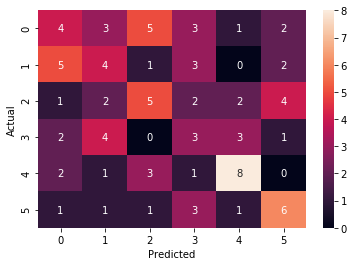

Linear SVM Confusion Matrix


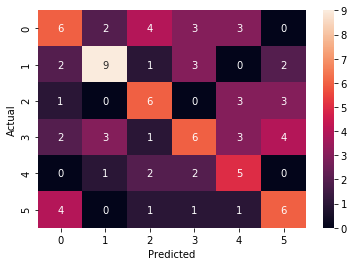

RBF SVM Confusion Matrix


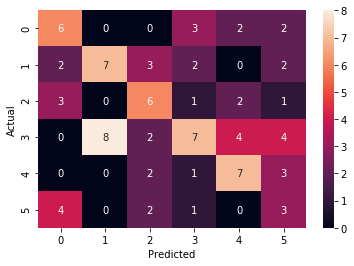

In [34]:
import pandas as pd
import seaborn as sn

print("KNN Confusion Matrix")
data = {'y_Actual':    y_pred_KNN,
        'y_Predicted': y_check
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion_matrix, annot=True)
plt.show()

print("Linear SVM Confusion Matrix")
data = {'y_Actual':    y_pred_lsvc,
        'y_Predicted': y_check
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion_matrix, annot=True)
plt.show()

print("RBF SVM Confusion Matrix")
data = {'y_Actual':    y_pred_rsvc,
        'y_Predicted': y_check
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion_matrix, annot=True)
plt.show()